In [1]:
import os, sys
sys.path.append("..")

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

import numpy as np
import torch
import torch.nn as nn
import torchvision
import gc

from src import distributions
import torch.nn.functional as F

from src.resnet2 import ResNet_D
from src.unet import UNet

from src.tools import unfreeze, freeze
from src.tools import load_dataset, get_pushed_loader_stats, get_Z_pushed_loader_stats
from src.fid_score import calculate_frechet_distance
from src.tools import weights_init_D
from src.tools import GradientClipper
from src.plotters import plot_random_Z_images, plot_Z_images

from copy import deepcopy
import json

In [2]:
def tensor2img(tensor):
    return tensor.to('cpu').permute(0, 2, 3, 1).mul(0.5).add(0.5).numpy().clip(0, 1)

In [3]:
DATASET1, DATASET1_PATH = 'handbag', '../../data/handbag_128.hdf5'
DATASET2, DATASET2_PATH = 'shoes', '../../data/shoes_128.hdf5'

IMG_SIZE = 64

device = "cuda:3"

torch.manual_seed(0xBADBEEF)
np.random.seed(0xBADBEEF)

X_sampler, X_test_sampler = load_dataset(DATASET1, DATASET1_PATH,
                                             img_size=IMG_SIZE, batch_size=32, device=device)
Y_sampler, Y_test_sampler = load_dataset(DATASET2, DATASET2_PATH,
                                             img_size=IMG_SIZE, batch_size=32, device=device)

torch.manual_seed(0xBADBEEF)
np.random.seed(0xBADBEEF)
X_fixed = X_sampler.sample(12)
Y_fixed = Y_sampler.sample(12)

X_test_fixed = X_test_sampler.sample(12)
Y_test_fixed = Y_test_sampler.sample(12)

Keys: KeysView(<HDF5 file "handbag_128.hdf5" (mode r)>)


/home/work/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


Keys: KeysView(<HDF5 file "shoes_128.hdf5" (mode r)>)


In [4]:
filename = '../stats/{}_{}_test.json'.format(DATASET2, IMG_SIZE)
with open(filename, 'r') as fp:
    data_stats = json.load(fp)
    mu_data, sigma_data = data_stats['mu'], data_stats['sigma']
del data_stats

## One-to-one model

In [5]:
path_to_model = "../checkpoints/mse/handbag_shoes_64/T.pt"

checkpoint = torch.load(path_to_model)

In [6]:
T = UNet(3, 3, base_factor=48)
T.load_state_dict(checkpoint)

T = T.to(device)
T.eval()

UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(48, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(96, eps=1e-05, momentum=0.

In [7]:
print('Computing FID')
# use_downloaded_weights=True if weights are going to be loaded from internet, otherwise place in inception.py a path to weights
mu, sigma = get_pushed_loader_stats(T, X_test_sampler.loader, device=device, 
                                    use_downloaded_weights=True)
fid = calculate_frechet_distance(mu_data, sigma_data, mu, sigma)

Computing FID


/home/work/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/home/work/anaconda3/lib/python3.6/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)


In [8]:
print(f"FID = {fid}")

FID = 13.76817862626342


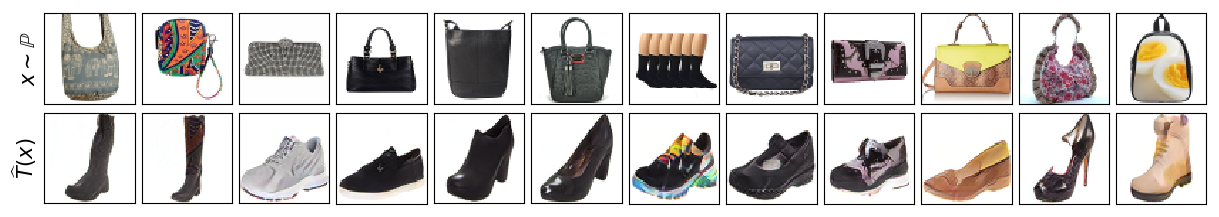

In [9]:
AB_test = T(X_test_fixed).detach()

fake_Y_test_numpy = tensor2img(AB_test)
real_X_test_numpy = tensor2img(X_test_fixed)

fig, axes = plt.subplots(2, 12, figsize=(12, 2), dpi=100)
X_tensor = real_X_test_numpy

for j in range(12):
    axes[0][j].imshow(X_tensor[j])
    axes[0][j].get_xaxis().set_visible(False)
    axes[0][j].set_yticks([])
    
    axes[1][j].imshow(fake_Y_test_numpy[j])
    axes[1][j].get_xaxis().set_visible(False)
    axes[1][j].set_yticks([])
        
axes[0, 0].set_ylabel(r'$x\sim\mathbb{P}$', fontsize=15)
title = '\widehat{T}(x)'
axes[1, 0].set_ylabel(r'${}$'.format(title), fontsize=15)
    
fig.tight_layout(pad=0.001)    
plt.savefig("ot_strong_bags2shoes_test.png")

## One-to-many model

In [5]:
def load_checkpoint(checkpoint):
    new_dict = {}
    start_len = len("module.")
    for key in checkpoint.keys():
        new_dict[key[start_len:]] = checkpoint[key]
        
    return new_dict

In [6]:
path_to_model = "../checkpoints/weak_mse/handbag_shoes_64/T.pt"

checkpoint = torch.load(path_to_model)
new_dict = load_checkpoint(checkpoint)

In [7]:
ZC = 1
Z_STD = 0.1
T = UNet(3+ZC, 3, base_factor=48)
T.load_state_dict(new_dict)

T = T.to(device)
T.eval()

UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(4, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(48, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(96, eps=1e-05, momentum=0.

In [8]:
torch.manual_seed(0xBADBEEF)
np.random.seed(0xBADBEEF)

num_calculation_fid = 10

fid_values = []

for i in range(num_calculation_fid):

    mu, sigma = get_Z_pushed_loader_stats(T, X_test_sampler.loader, ZC=ZC, Z_STD=Z_STD, device=device, 
                                          use_downloaded_weights=True)
    fid = calculate_frechet_distance(mu_data, sigma_data, mu, sigma)
    print(f"FID = {fid}")
    fid_values.append(fid)
fid_values = np.array(fid_values)
fid_mean = np.mean(fid_values)
fid_std = np.std(fid_values)
print("--------")
print(f"Mean FID = {fid_mean}")
print(f"Std FID = {fid_std}")

/home/work/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/home/work/anaconda3/lib/python3.6/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)


FID = 13.432677064447887
FID = 13.214624358367502
FID = 13.55941081263174
FID = 13.570873571784574
FID = 13.541128406382228
FID = 13.28342947311188
FID = 13.524782390332831
FID = 13.4663260680787
FID = 13.511491864600572
FID = 13.383602173563759
--------
Mean FID = 13.448834618330167
Std FID = 0.11505143890897332


In [19]:
torch.manual_seed(24)
np.random.seed(24)

num_examples = 4
Y_test_fakes = []

for v in range(num_examples):
    Z = torch.randn(X_test_fixed.size(0), ZC, X_test_fixed.size(2), X_test_fixed.size(3), device=device) * Z_STD
    X = X_sampler.sample(10)[:,None].repeat(1,4,1,1,1)
    XZ = torch.cat([X_test_fixed, Z], dim=1)
    
    fake_Y_test = T(XZ).detach()
    fake_Y_test_numpy = tensor2img(fake_Y_test)
    Y_test_fakes.append(fake_Y_test_numpy)

real_X_test_numpy = tensor2img(X_test_fixed)
real_Y_test_numpy = tensor2img(Y_test_fixed)

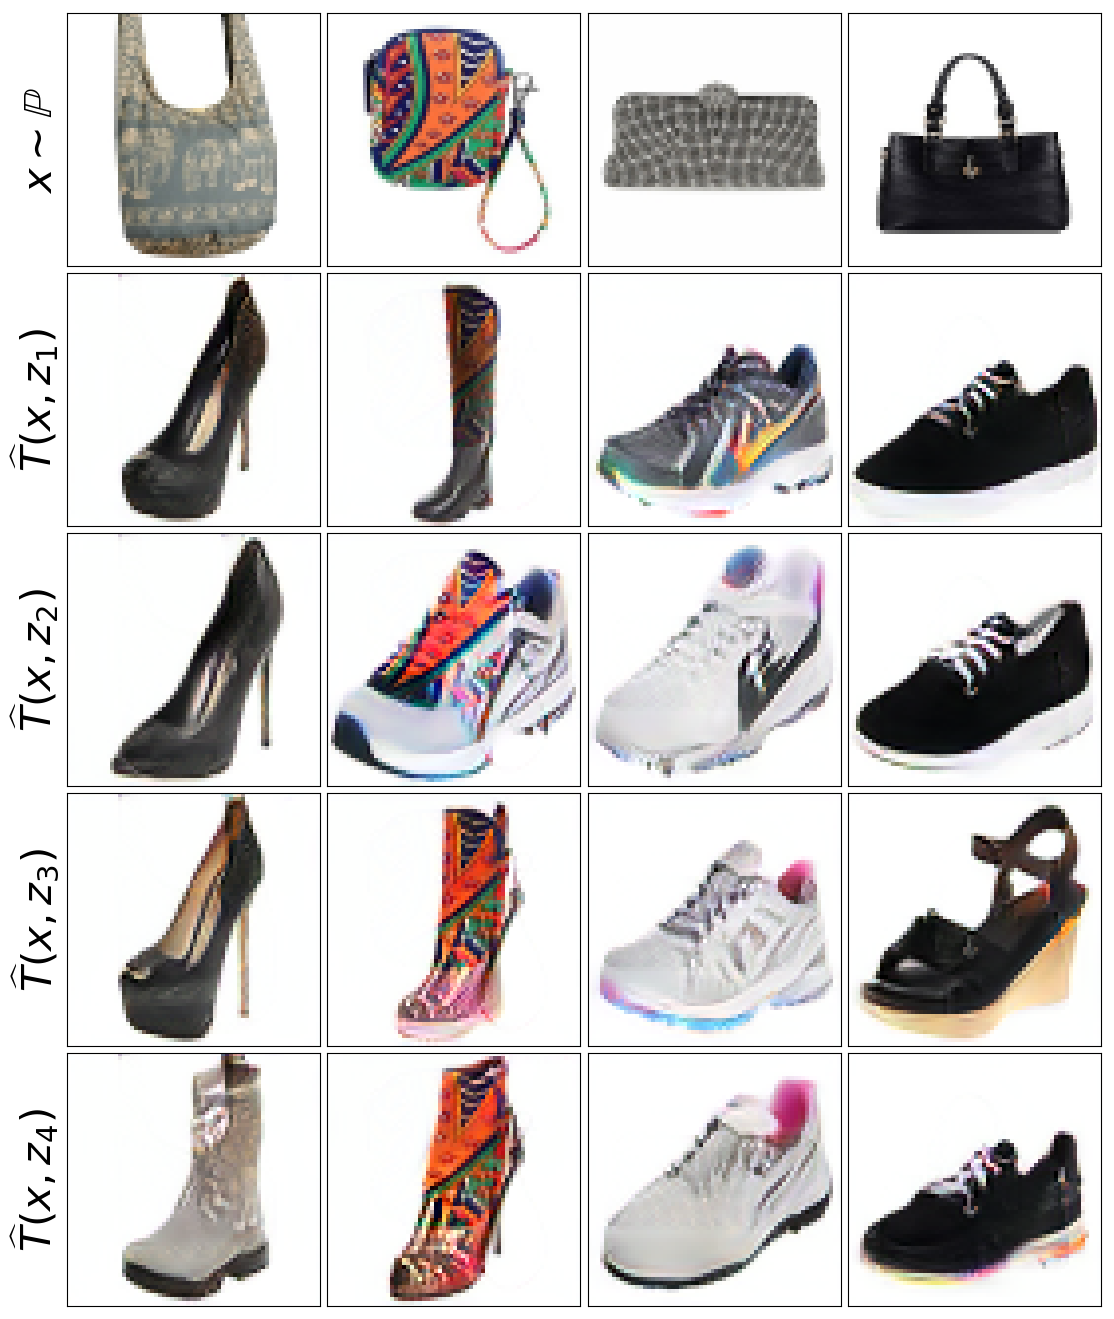

In [20]:
fig, axes = plt.subplots(5, 4, figsize=(11, 13), dpi=100)
X_tensor = real_X_test_numpy
Y_tensor = real_Y_test_numpy
Y_fake_tensor = Y_test_fakes

for j in range(4):
    axes[0][j].imshow(X_tensor[j])
    axes[0][j].get_xaxis().set_visible(False)
    axes[0][j].set_yticks([])
    #axes[0][j].get_yaxis().set_visible(False)

for i in range(4):
    for j in range(4):
        cur_img = Y_fake_tensor[i][j]

        axes[i + 1][j].imshow(cur_img)
        axes[i + 1][j].get_xaxis().set_visible(False)
        axes[i + 1][j].set_yticks([])
        #axes[i + 1][j].get_yaxis().set_visible(False)
        
axes[0, 0].set_ylabel(r'$x\sim\mathbb{P}$', fontsize=30)
for j in range(4):
    title = '\widehat{T}(x,z_' + str(j+1) + ')'
    axes[j+1, 0].set_ylabel(r'${}$'.format(title), fontsize=30)
    
fig.tight_layout(pad=0.001)    
plt.savefig("weak_ot_bags2shoes_test_2.png")